In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [35]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5] #print first 5 words

['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']

In [36]:
words=[x.lower() for x in words] #lowwrcasing all words

In [37]:
len(words)

7944

In [38]:
# build the vocabulary of characters and  mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))  #so vocabulary length is 30

30


In [6]:
# build the dataset
block_size = 3 # context length

def build_dataset(words,st):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop context and append next character

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print('{0} size is ---->   examples: {1} and targets is {2} '.format(st,X.shape, Y.shape))
  return X, Y

In [7]:
#building train 80% ,validation 10% ,test data 10% splits
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1],'Training')
Xdev, Ydev = build_dataset(words[n1:n2],'Validation')
Xte, Yte = build_dataset(words[n2:],'Testing')

Training size is ---->   examples: torch.Size([44725, 3]) and targets is torch.Size([44725]) 
Validation size is ---->   examples: torch.Size([5599, 3]) and targets is torch.Size([5599]) 
Testing size is ---->   examples: torch.Size([5544, 3]) and targets is torch.Size([5544]) 


In [8]:
# Xtr=Xtr.float()
# Ytr=Ytr.float()
# Xdev=Xdev.float()
# Ydev=Ydev.float()

In [9]:
#init the neural net
dim=10
hidden=200
gain=5/3
C = torch.randn((len(itos), dim))  # 10 dimensional lookup table for vocabulary size.
W1 = torch.randn((block_size*dim, hidden))* gain/((block_size*dim)**0.5) #3*10=30 (context * dim= size of one input)
#b1 = torch.randn(hidden) * 0
W2 = torch.randn((hidden, len(itos))) * 0.01
b2 = torch.randn(len(itos)) * 0
scale=torch.ones(1,hidden)*0.01
shift=torch.zeros(1,hidden)*0.01
parameters = [C, W1,scale,shift, W2, b2] #b1 not req

In [10]:
sum(p.nelement() for p in parameters) # number of parameters in total

12730

In [11]:
#setting requires_grad=True for all parameters
for p in parameters:
  p.requires_grad = True 

In [23]:
#init parameters for training
lossi = []
stepi = []
epochs=100000
lr=0.01
alpha=0.1
batch_size=32
first_mom=0
second_mom=0
first_mom=first_mom/(1-0.9*100)
second_mom=second_mom/(1-0.999*100)

In [24]:
#C[Xtr] === C @ one_hot of Xtr example

In [41]:
for i in range(epochs+1):
    #sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    #forward pass
    emb=C[Xtr] # projecting each character to 10 dim 
    normli1= C[Xtr[ix]].view(-1,block_size*dim) @ W1 #+ b1
    
    #batch normalization
    normli= (normli1-normli1.mean(axis=0,keepdim=True))/normli1.std(axis=0,keepdim=True)
    normli=normli*scale + shift
    
    
    temp=torch.tanh(normli)
    logits= temp @ W2 + b2
    
    #softmax
    counts = logits.exp() 
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    
    #negative log likelyhood loss loss fn
    loss = -probs[torch.arange(len(Xtr[ix])), Ytr[ix]].log().mean() + alpha*(W1**2).mean()
 
    #backward pass
    for p in parameters:
        p.grad=None
        
    loss.backward()

    #parameter update
    for p in parameters:
        lr=0.01 if i<10000 else 0.1 
        p.data-=lr*p.grad
        
      #adam update
#     for p in parameters:
#         print(p.grad.shape)
#         first_mom=0.9*first_mom+0.1*p.grad
#         second_mom=0.999*second_mom+0.001*p.grad**2
#         eff_lr=1/((second_mom**2+0.00001)**0.5)
#         p.data-=eff_lr*first_mom

    if(i%5000==0):
        print('loss at {0} iteration is {1}'.format(i+1,loss.item()))
    
    
    #for stats
    stepi.append(i)
    lossi.append(loss.item())
    

loss at 1 iteration is 2.5834903717041016
loss at 5001 iteration is 2.1327292919158936
loss at 10001 iteration is 2.0441415309906006
loss at 15001 iteration is 1.8372997045516968
loss at 20001 iteration is 2.0371363162994385
loss at 25001 iteration is 2.100309371948242
loss at 30001 iteration is 2.081117868423462
loss at 35001 iteration is 2.198269844055176
loss at 40001 iteration is 1.8516473770141602
loss at 45001 iteration is 2.2413129806518555
loss at 50001 iteration is 2.1094748973846436
loss at 55001 iteration is 1.667232871055603
loss at 60001 iteration is 2.1863088607788086
loss at 65001 iteration is 2.4835562705993652
loss at 70001 iteration is 1.7741042375564575
loss at 75001 iteration is 1.740194320678711
loss at 80001 iteration is 1.9886850118637085
loss at 85001 iteration is 2.117891788482666
loss at 90001 iteration is 1.8746719360351562
loss at 95001 iteration is 2.1343894004821777
loss at 100001 iteration is 2.233757972717285


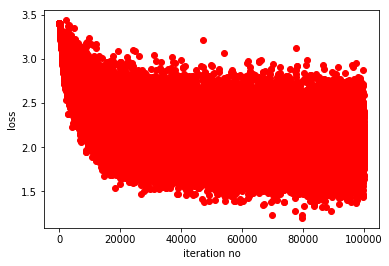

In [15]:
#plotting stpes vs loss
plt.plot(stepi,lossi,'ro')
plt.xlabel("iteration no")
plt.ylabel('loss')

plt.show()

In [42]:
#loss for validation set
#sample a batch
ix = torch.randint(0, Xdev.shape[0], (batch_size,))

#forward pass
emb=C[Xdev] # projecting each character to 10 dim 
normli1= C[Xdev[ix]].view(-1,block_size*dim) @ W1 #+ b1

#batch normalization
normli= (normli1-normli1.mean(axis=0,keepdim=True))/normli1.std(axis=0,keepdim=True) #or calculate running and var with momentum.
normli=normli*scale + shift


temp=torch.tanh(normli)
logits= temp @ W2 + b2

#softmax
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

#negative log likelyhood loss loss fn
loss_dev = -probs[torch.arange(len(Xdev[ix])), Ydev[ix]].log().mean() + alpha*(W1**2).mean()

print('loss for validation set is {0}'.format(loss_dev))

loss for validation set is 2.2997658252716064


In [51]:
#loss for test set
#sample a batch
ix = torch.randint(0, Xte.shape[0], (batch_size,))

#forward pass
emb=C[Xte] # projecting each character to 10 dim 
normli1= C[Xte[ix]].view(-1,block_size*dim) @ W1 #+ b1

#batch normalization
normli= (normli1-normli1.mean(axis=0,keepdim=True))/normli1.std(axis=0,keepdim=True) #or calculate running and var with momentum.
normli=normli*scale + shift


temp=torch.tanh(normli)
logits= temp @ W2 + b2

#softmax
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

#negative log likelyhood loss loss fn
loss_te = -probs[torch.arange(len(Xte[ix])), Yte[ix]].log().mean() + alpha*(W1**2).mean()

print('loss for test set is {0}'.format(loss_te))

loss for test set is 2.0711169242858887


In [21]:
# sample from the model
for i in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,dim)
      temp = (emb.view(1, -1) @ W1 )
      temp=temp-temp.mean()/temp.std()
      temp=temp*scale+shift
      h=torch.tanh(temp)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

josangel.
dannteth.
ufwudleva.
darg.
dorest.
adgenusthpe.
pannustia.
dugta.
strest.
aggiddanne.


In [19]:
# samples from the model
# 1)normal implementatoin 
# felgrlnna.
# mar.
# tiph.
# rey.
# aatia.
# ald.
# tibe.
# juspattan.
# fzopseffiegane.
# macy.

# 2)normal implementaion + good init of network + batch normalization
# agretti.
# plarmeliannethioshe.
# darconsoliquettts.
# ddt.
# jomatqe.
# did.
# panny.
# digita.
# lappengel.



#3)normal implementaion + good init of network + batch normalization + adam optimizer
#nerdre.
#lerome.
#sterrie.
#neila.
#martie.
#and.
#josette.
#ciley.
#romeo.
#ira.